In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### We are loading 2 of the datasets one of them is the JIGSAW toxic comment classification dataset from kaggle and other one is youtube toxic comments dataset. 

- First step is to load both the datasets

In [7]:
df1 = pd.read_csv('F:\\Text\\Hate_Classifier\\Kaggle Dataset\\train.csv\\train.csv')
df2 = pd.read_csv('F:\\Text\\Hate_Classifier\\Kaggle Dataset\\youtoxic_english_1000.csv')

- We are verifying if the loaded dataset is right by printing some values 

In [8]:
df1.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


- Same goes for second dataset too

In [9]:
df2.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\r\nDont you reckon them 'black lives matter' ...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


- This part of the notebook processes the 2 datasets and extracts relevant information for setting up a binary classification pipeline

- `df1['Toxic'] = df1.iloc[:, 2:].any(axis=1)` This is the part where the entire dataset from third column from the dataset 1 is chosen and if there are any values which are true the entire `comment_text` is set as true for a new column namely `toxic`.Even the `comment_text` is renamed to `text` for consistency

- `df2['Toxic'] = df2.iloc[:, 3:].any(axis=1)` This is the part where the entire dataset from 4th column from the dataset 2 is chosen and if there are any values which are true the entire `comment_text` is set as true for a new column namely `toxic`.Even the `comment_text` is renamed to `text` for consistency

In [10]:
# Process df1
df1['Toxic'] = df1.iloc[:, 2:].any(axis=1)
df1_processed = df1[['comment_text', 'Toxic']].rename(columns={'comment_text': 'Text'})

# Process df2
df2['Toxic'] = df2.iloc[:, 3:].any(axis=1)
df2_processed = df2[['Text', 'Toxic']]

# Combine df1_processed and df2_processed
df = pd.concat([df1_processed, df2_processed], ignore_index=True)


In [11]:
df.describe()

,Text,Toxic
count,160571,160571
unique,160568,2
top,run them over,False
freq,3,143884


- Here in dataset description we can see that there are some duplicate values, So we proceed to removing that.

In [12]:
# Check for duplicate comments
duplicate_rows = df[df.duplicated(subset=['Text'], keep=False)]
print("Duplicate rows based on 'Text' column:")
print(duplicate_rows)

# Drop duplicate comments
df.drop_duplicates(subset=['Text'], keep='first', inplace=True)

# Confirm duplicates are removed
print("Number of rows after removing duplicates:", len(df))

# Reindex the DataFrame after dropping duplicates
df.reset_index(drop=True, inplace=True)

Duplicate rows based on 'Text' column:
                 Text  Toxic
160163  RUN THEM OVER   True
160213  run them over   True
160228  run them over   True
160248  run them over   True
160270  RUN THEM OVER   True
Number of rows after removing duplicates: 160568


In [13]:
# Distribution of 'Toxic' column
toxic_distribution = df['Toxic'].value_counts()
print(toxic_distribution)

Toxic
False    143884
True      16684
Name: count, dtype: int64


- Once that is done, we are checking the distribution of the dataset only to notice a drastic difference in the data balance. Such a huge imbalance in data can cause very big issues.


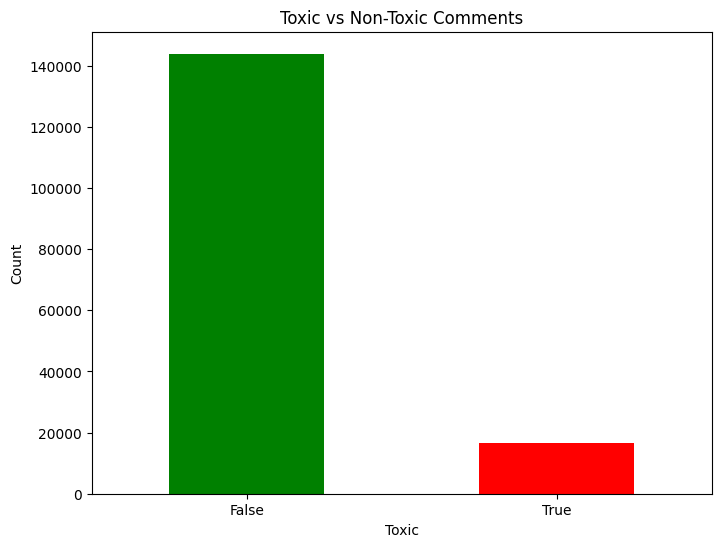

In [14]:
# Bar plot for toxic vs non-toxic comments
plt.figure(figsize=(8, 6))
toxic_counts = df['Toxic'].value_counts()
toxic_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Toxic vs Non-Toxic Comments')
plt.xlabel('Toxic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

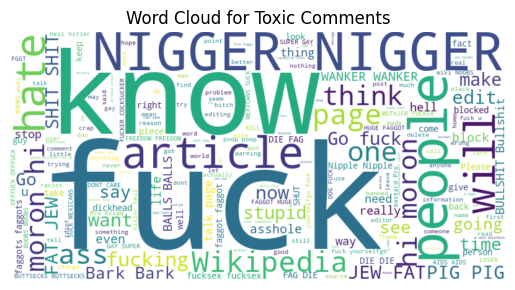

In [15]:
# Word Cloud for toxic and non-toxic comments
toxic_comments = ' '.join(df[df['Toxic']]['Text'])
wordcloud_toxic = WordCloud(width=800, height=400, background_color='white').generate(toxic_comments)
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Comments')
plt.show()

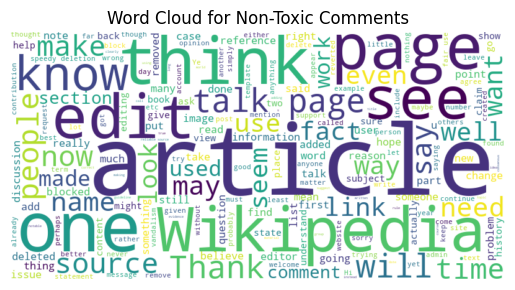

In [16]:
non_toxic_comments = ' '.join(df[~df['Toxic']]['Text'])
wordcloud_non_toxic = WordCloud(width=800, height=400, background_color='white').generate(non_toxic_comments)
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Toxic Comments')
plt.show()

- We are converting true - 1 and false - 0 ( encoding for the model )

In [17]:
df['Toxic'] = df['Toxic'].astype(int)

- Expanding shortforms and cleaning the text without using any inbuilt functions. Uploaded the dataset to ChatGPT and asked it to give the words commonly used in shortform and using regex it was expanded.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [19]:
df['Text'] = df['Text'].map(lambda com : clean_text(com))

- As said earlier we are using ADASYN to bring a balance to the different classes, It works better for high dimensional data ( TF-IDF produces high dimensional data).
- ADASYN introduces randomness, It makes sure that new samples dont just mirror the existing ones leading to a better generalisation

In [20]:
# Vectorize the text data using TF-IDF
vect = TfidfVectorizer(max_features=5000, stop_words='english')
X = vect.fit_transform(df['Text'])
Y = df['Toxic']

In [38]:
print(X.shape)

(160568, 5000)


In [21]:
from imblearn.over_sampling import ADASYN

# Initialize ADASYN
adasyn = ADASYN()

# Apply ADASYN for oversampling
X_resampled, y_resampled = adasyn.fit_resample(X, Y)

In [22]:
# Convert the oversampled data back to a DataFrame
df_resampled = pd.DataFrame(X_resampled.todense(), columns=vect.get_feature_names_out())
df_resampled['Toxic'] = y_resampled

# Check the distribution after oversampling
toxic_distribution_after = df_resampled['Toxic'].value_counts()
print("\nDistribution after ADASYN:")
print(toxic_distribution_after)


Distribution after ADASYN:
Toxic
1    146136
0    143884
Name: count, dtype: int64


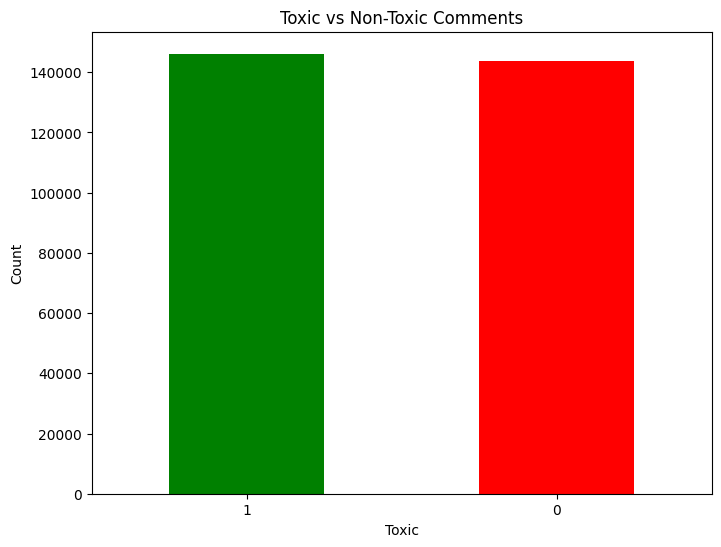

In [23]:
# Bar plot for toxic vs non-toxic comments
plt.figure(figsize=(8, 6))
toxic_counts = df_resampled['Toxic'].value_counts()
toxic_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Toxic vs Non-Toxic Comments')
plt.xlabel('Toxic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

- As we are choosing a traditional ML based pipeline, We are using TF-IDF vectorisation. Implementing what we learnt in the classroom, TF-IDF seemed better than one hot or bag of words because TF-IDF gives more weightage to important words ( we saw that in word cloud ). It works better for Large datasets

## Model Building and training

- 1 - Input ( Tokenized Text )
- 2 - TF-IDF is done then the input is sent to the LSTM layers 
- 3 - LSTM as hidden dimension of 256 so Bi-Directional means 256 + 256 = 512 
- 4 - [32,5000,512] -  (batch_size, sequence_length, hidden_dim × 2)
- 5 - This 512 features from a token which the BLSTM produces is converted to an attention score. ( each token gets an attention score now ).
- 6 - The fully connected layer now converts the 512 ( input from BLSTM ) into 2 classes for binary classification
- 7 - Dropout(p=0.3, inplace=False) This is dropout layer which ensures overfitting is not done ( we drop out 30% of the neurons)

**Finally softmax is done and if class 1 has higher probability its toxic and if class 0 has higher probability its non-toxic**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()

class BiLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))  # Ensure proper shape for LSTM
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # Attention mechanism
        attn_out = torch.sum(lstm_out * attn_weights, dim=1)
        output = self.fc(self.dropout(attn_out))
        return output

In [27]:
input_dim = X_resampled.shape[1]  # TF-IDF feature dimension
hidden_dim = 256
output_dim = 2  # Binary classification

model = BiLSTMAttention(input_dim, hidden_dim, output_dim).to(device)
model.to(device)
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Ensure device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train.todense(), dtype=torch.float32), 
                              torch.tensor(y_train.values, dtype=torch.long))  
test_dataset = TensorDataset(torch.tensor(X_test.todense(), dtype=torch.float32), 
                              torch.tensor(y_test.values, dtype=torch.long))  


# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training function
def train_model(model, train_dataloader, epochs=20):
    model.train()
    train_losses = []  # Store losses for plotting
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch.float())  # Ensure inputs are float tensors
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_loss)  # Store loss
        print(f"Epoch {epoch+1}, Loss: {avg_loss}")
    
    torch.save(model.state_dict(), "bilstm_toxicity_model.pth")
    print("Model saved successfully.")
    return train_losses  # Return loss values

# Train the model and store loss values
train_losses = train_model(model, train_dataloader)

# **Plot Training Loss**
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch.float())
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return all_labels, all_preds

# Evaluate the model on the test set
labels, preds = evaluate_model(model, test_dataloader)



Accuracy: 0.9747
Precision: 0.9548
Recall: 0.9972
F1-score: 0.9755


# Classification of a random comment

In [29]:
# Load the model for evaluation
model.load_state_dict(torch.load("bilstm_toxicity_model.pth"))
model.to(device)
model.eval()

BiLSTMAttention(
  (lstm): LSTM(5000, 256, batch_first=True, bidirectional=True)
  (attention): Linear(in_features=512, out_features=1, bias=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to classify a single comment
def classify_comment(comment, model, vectorizer):
    model.eval()
    with torch.no_grad():
        comment_vector = vectorizer.transform([comment]).todense()
        comment_tensor = torch.tensor(comment_vector, dtype=torch.float32).to(device)
        output = model(comment_tensor)
        prediction = torch.argmax(output, dim=1).item()
        return "Toxic" if prediction == 1 else "Non-Toxic"

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Load the saved TF-IDF vectorizer (if previously saved)
try:
    with open("tfidf_vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)
    print("Vectorizer loaded successfully.")
except FileNotFoundError:
    print("Error: Vectorizer file not found. Ensure you save the vectorizer during training.")

# Function to classify a single comment
def classify_comment(comment, model, vectorizer):
    model.eval()
    with torch.no_grad():
        comment_vector = vectorizer.transform([comment]).todense()  # Transform input text
        comment_tensor = torch.tensor(comment_vector, dtype=torch.float32).to(device)
        output = model(comment_tensor)
        prediction = torch.argmax(output, dim=1).item()
        return "Toxic" if prediction == 1 else "Non-Toxic"

Vectorizer loaded successfully.


In [36]:
# Get user input and classify
user_comment = input("Enter a comment: ")
print("Comment Classification:", classify_comment(user_comment, model, vectorizer))

Comment Classification: Toxic
